# Types of roles women portray 

#### What types of characters do women portray and how are these roles linked to their physical profiles?

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic. Women are rarely identified solely by work-related role in cinema, and thus do no really have identifiable occupations.






## Data handling, preprocessing, descriptive statistics 
In this part we wil explore the characters and their types using the dataset availables in **DATA** that we already started to prepocess in a pervious part: **character_metadata,csv** and the already provided data **tvtropes.clusters.txt**.

Features summary and content:

**character_metadata**
* 1. Wikipedia movie ID
* 2. Freebase movie ID
* 3. Movie release date
* 4. Character name
* 5. Actor date of birth
* 6. Actor gender
* 7. Actor height (in meters)
* 8. Actor ethnicity (Freebase ID)
* 9. Actor name
* 10. Actor age at movie release
* 11. Freebase character/actor map ID
* 12. Freebase character ID
* 13. Freebase actor ID

**tvtropes.clusters.txt**

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline
import re
import seaborn as sns
import ast

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats

### Load the data 

In [3]:
# Load the characters dataset
characters = pd.read_csv('Data/character_metadata.csv')

# Load the tropes dataset as a tab-separated file
tropes = pd.read_csv('Data/MovieSummaries/tvtropes.clusters.txt', sep='\t', header=None, names=['trope', 'data'], engine='python')
# Parse the JSON strings in the 'data' column of the tropes dataset
tropes['data'] = tropes['data'].apply(ast.literal_eval)
# Normalize the 'data' dictionaries into separate columns
data_expanded = pd.json_normalize(tropes['data'])
# Combine the 'trope' column with the expanded data columns
tropes = pd.concat([tropes['trope'], data_expanded], axis=1)


# Load the summaries : read the file into a dataFrame and skips lines with parsing errors
summary = pd.read_csv('Data/MovieSummaries/plot_summaries.txt',sep='\t',header=None, names=['wiki_id', 'summary'], encoding='utf-8', on_bad_lines='skip')
# Convert 'wiki_id' to string 
#summary['wiki_id'] = summary['wiki_id'].astype(str)


* Display the first few rows of each dataframe

In [4]:
print("Tropes dataframe:")
tropes.head()

Tropes dataframe:


,trope,char,movie,id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


In [5]:
print("\nCharacters dataframe:")
characters.head()


Characters dataframe:


,Wiki_ID,Movie_ID,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age_movie_released,character/actor_ID,character_ID,Actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [6]:
print("Summary dataframe:")
summary.head()

Summary dataframe:


,wiki_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


### Data Understanding and Preprocessing


In [7]:
# Check for missing values, and added the value needed about the gender that was missing 
print("Missing values in tropes dataset:\n", tropes.isnull().sum())


Missing values in tropes dataset:
 trope    0
char     0
movie    0
id       0
actor    0
dtype: int64


###  Data Enrichment
* Enrichment of the tropes dataset with additional characteristics from the characters dataset (e.g., gender, height, ethnicity, age at release).

In [8]:
# Ensure the actor column is named consistently in both DataFrames
characters.rename(columns={'actor_name': 'actor'}, inplace=True)

# Create a dictionary mapping from actor to gender
gender_mapping = characters.set_index('actor')['actor_gender'].to_dict()
height_mapping = characters.set_index('actor')['actor_height'].to_dict()
ethnicity_mapping = characters.set_index('actor')['actor_ethnicity'].to_dict()
age_mapping = characters.set_index('actor')['actor_age_movie_released'].to_dict()

# Use the mapping to add the gender column in tropes based on the actor column
tropes['actor_gender'] = tropes['actor'].map(gender_mapping)
tropes['actor_height'] = tropes['actor'].map(height_mapping)
tropes['actor_ethnicity'] = tropes['actor'].map(ethnicity_mapping)
tropes['actor_age_movie_released'] = tropes['actor'].map(age_mapping)

# Display the updated DataFrame
print("Tropes DataFrame with Gender Column Added:")
tropes.head()

Tropes DataFrame with Gender Column Added:


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0


In [9]:
# Check for missing values, and added the value needed about the gender that was missing
print("Missing values in tropes dataset:\n", tropes['actor_gender'].isnull().sum())
tropes.loc[tropes['actor_gender'].isnull(), 'actor_gender'] = 'M'
print("Missing values in tropes dataset:\n", tropes['actor_gender'].isnull().sum())

Missing values in tropes dataset:
 1
Missing values in tropes dataset:
 0


* Fiter: seperate female characters from mens

In [10]:
tropes_w = tropes.loc[tropes['actor_gender'] =='F']
tropes_w.head()


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
8,adventurer_archaeologist,Evelyn Carnahan-O'Connell,The Mummy,/m/0k5yzc,Rachel Weisz,F,1.70,/m/013b6_,23.0
11,arrogant_kungfu_guy,Jen Yu,"Crouching Tiger, Hidden Dragon",/m/0jwv09,Zhang Ziyi,F,1.63,NaN,28.0
35,brainless_beauty,Gemma Honeycutt,Fool's Gold,/m/04dddz5,Alexis Dziena,F,1.57,/m/0xnvg,18.0
38,brainless_beauty,Shelley Darlingson,The House Bunny,/m/04dgw4t,Anna Faris,F,1.65,/m/07bch9,28.0
39,brainless_beauty,Brace Channing,My Favorite Martian,/m/03lvf22,Elizabeth Hurley,F,1.73,/m/02w7gg,35.0


In [11]:

tropes_m = tropes.loc[tropes['actor_gender'] =='M']
tropes_m.head()

,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0


### Calculating descriptive statistics 
* let's calculate basic descriptive statistics of the trope

In [12]:
tropes_w['trope'].describe()


count              69
unique             21
top       dumb_blonde
freq               10
Name: trope, dtype: object

In [15]:
print('All the tropes we find women in are\n',tropes_w['trope'].unique())


All the tropes we find women in are
 ['adventurer_archaeologist' 'arrogant_kungfu_guy' 'brainless_beauty'
 'broken_bird' 'bully' 'chanteuse' 'classy_cat_burglar' 'ditz' 'doormat'
 'dumb_blonde' 'eccentric_mentor' 'final_girl' 'granola_person'
 'heartbroken_badass' 'junkie_prophet' 'klutz' 'ophelia' 'prima_donna'
 'slacker' 'storyteller' 'valley_girl']


In [16]:
tropes_m['trope'].describe()

count                   432
unique                   65
top       crazy_jealous_guy
freq                     25
Name: trope, dtype: object

In [17]:
print('All the tropes we find men in are\n',tropes_m['trope'].unique())

All the tropes we find men in are
 ['absent_minded_professor' 'adventurer_archaeologist'
 'arrogant_kungfu_guy' 'big_man_on_campus' 'bounty_hunter'
 'brainless_beauty' 'broken_bird' 'bromantic_foil'
 'bruiser_with_a_soft_center' 'bully' 'byronic_hero' 'casanova' 'charmer'
 'child_prodigy' 'consummate_professional' 'corrupt_corporate_executive'
 'coward' 'crazy_jealous_guy' 'crazy_survivalist' 'cultured_badass'
 'dean_bitterman' 'dirty_cop' 'ditz' 'doormat' 'drill_sargeant_nasty'
 'dumb_blonde' 'dumb_muscle' 'eccentric_mentor' 'egomaniac_hunter'
 'evil_prince' 'fastest_gun_in_the_west' 'father_to_his_men'
 'gadgeteer_genius' 'gentleman_thief' 'granola_person' 'grumpy_old_man'
 'hardboiled_detective' 'heartbroken_badass' 'henpecked_husband'
 'hitman_with_a_heart' 'jerk_jock' 'klutz' 'loser_protagonist'
 'loveable_rogue' 'master_swordsman' 'morally_bankrupt_banker'
 'officer_and_a_gentleman' 'playful_hacker' 'psycho_for_hire'
 'pupil_turned_to_evil' 'retired_outlaw' 'revenge' 'romantic_ru

* Distribution of each trope for both women and men, to see which tropes are more frequently associeted with each gender

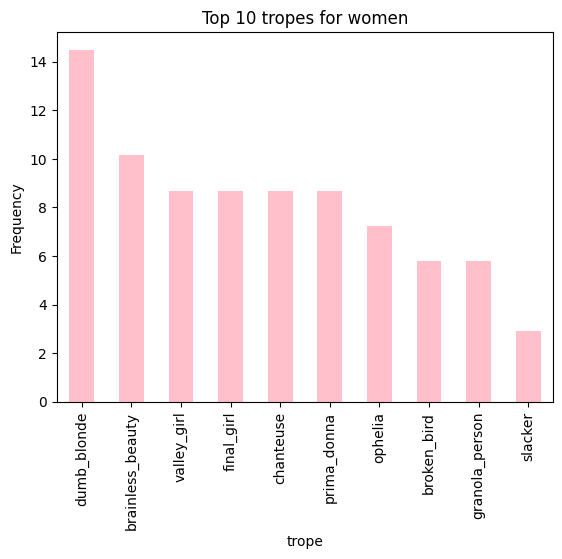

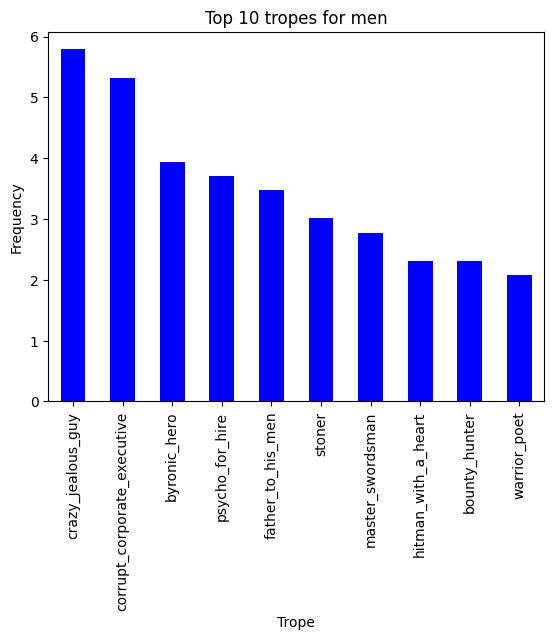

In [27]:
tropes_w_distribution = tropes_w['trope'].value_counts(normalize=True) * 100
tropes_m_distribution = tropes_m['trope'].value_counts(normalize=True) * 100
top_tropes_w = tropes_w_distribution.head(10)
top_tropes_m = tropes_m_distribution.head(10)

# Plotting the top 10 tropes for women and men
top_tropes_w.plot(kind='bar', title='Top 10 tropes for women', color='pink')
plt.ylabel('Frequency')
plt.show()
# Plot the top 10 tropes for men
top_tropes_m.plot(kind='bar', title = 'Top 10 tropes for men',color='blue')
plt.ylabel('Frequency')
plt.xlabel('Trope')
plt.show()

* Average age of actors by tropes, to see if certain tropes are associated with different age groupes

C:\Users\Myriam Charfeddine\AppData\Local\Temp\ipykernel_14956\1753443139.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tropes_by_age_group_w = tropes_w.groupby(['age_group', 'trope']).size().unstack(fill_value=0)
C:\Users\Myriam Charfeddine\AppData\Local\Temp\ipykernel_14956\1753443139.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tropes_by_age_group_m = tropes_m.groupby(['age_group', 'trope']).size().unstack(fill_value=0)


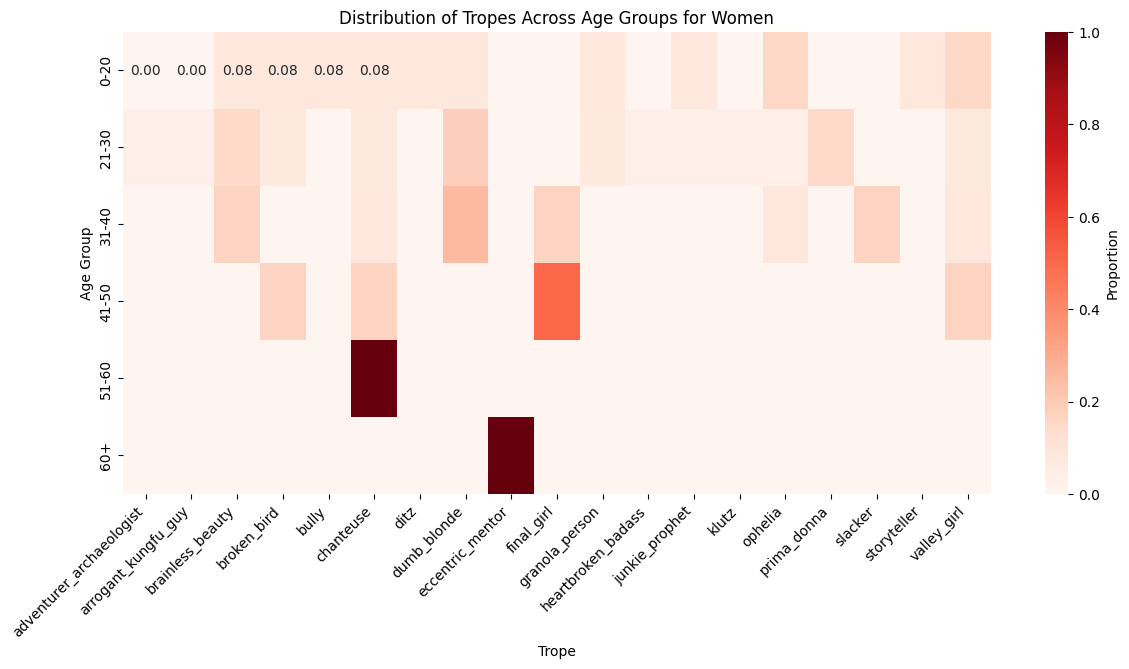

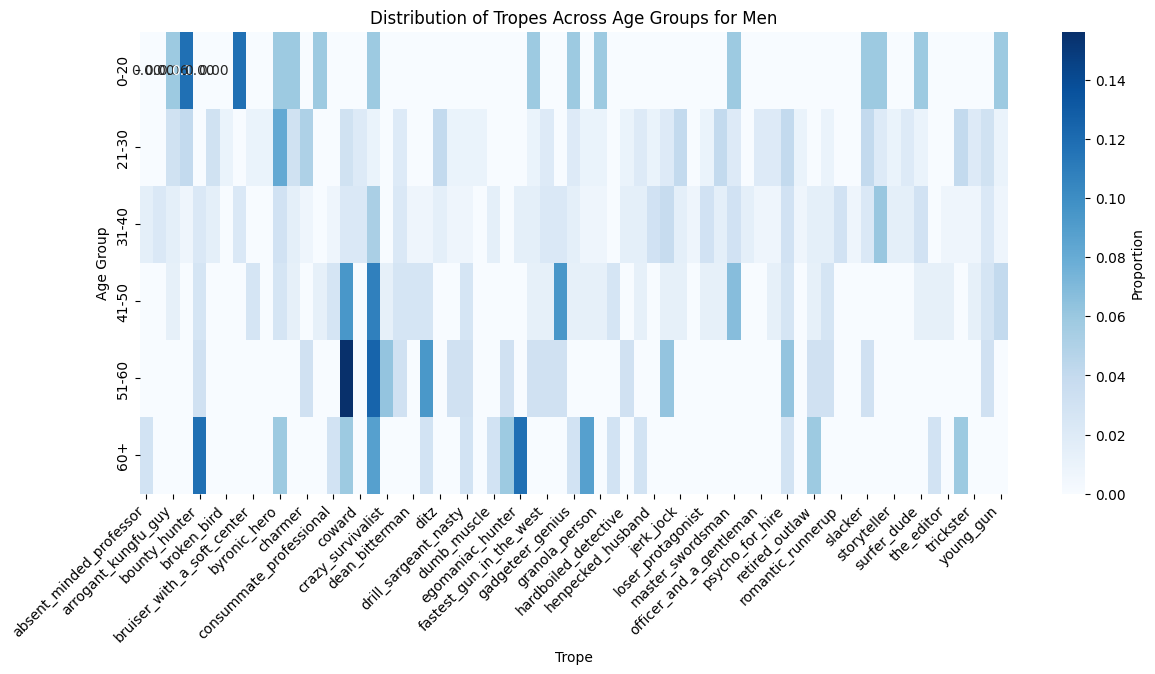

In [35]:
# Categorize age into groups
age_bins = [0, 20, 30, 40, 50, 60, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '60+']
tropes_w['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)
tropes_m['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)

#  distribution of tropes within each age group
tropes_by_age_group_w = tropes_w.groupby(['age_group', 'trope']).size().unstack(fill_value=0)
tropes_by_age_group_m = tropes_m.groupby(['age_group', 'trope']).size().unstack(fill_value=0)

# normalize within each age group to get the proportion of each trope
tropes_by_age_group_w = tropes_by_age_group_w.div(tropes_by_age_group_w.sum(axis=1), axis=0)
tropes_by_age_group_m = tropes_by_age_group_m.div(tropes_by_age_group_m.sum(axis=1), axis=0)


plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_age_group_w, cmap='Reds', annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title("Distribution of Tropes Across Age Groups for Women")
plt.xlabel("Trope")
plt.ylabel("Age Group")
plt.xticks(rotation=45, ha='right')
plt.show()

#Plot the heatmap for men
plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_age_group_m, cmap='Blues', annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title("Distribution of Tropes Across Age Groups for Men")
plt.xlabel("Trope")
plt.ylabel("Age Group")
plt.xticks(rotation=45, ha='right')
plt.show()

* Average Height by Trope

C:\Users\Myriam Charfeddine\AppData\Local\Temp\ipykernel_14956\2990496804.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_distribution_m = tropes_m.groupby(['trope', 'height_category']).size().unstack().fillna(0)
C:\Users\Myriam Charfeddine\AppData\Local\Temp\ipykernel_14956\2990496804.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  height_distribution_w = tropes_w.groupby(['trope', 'height_category']).size().unstack().fillna(0)


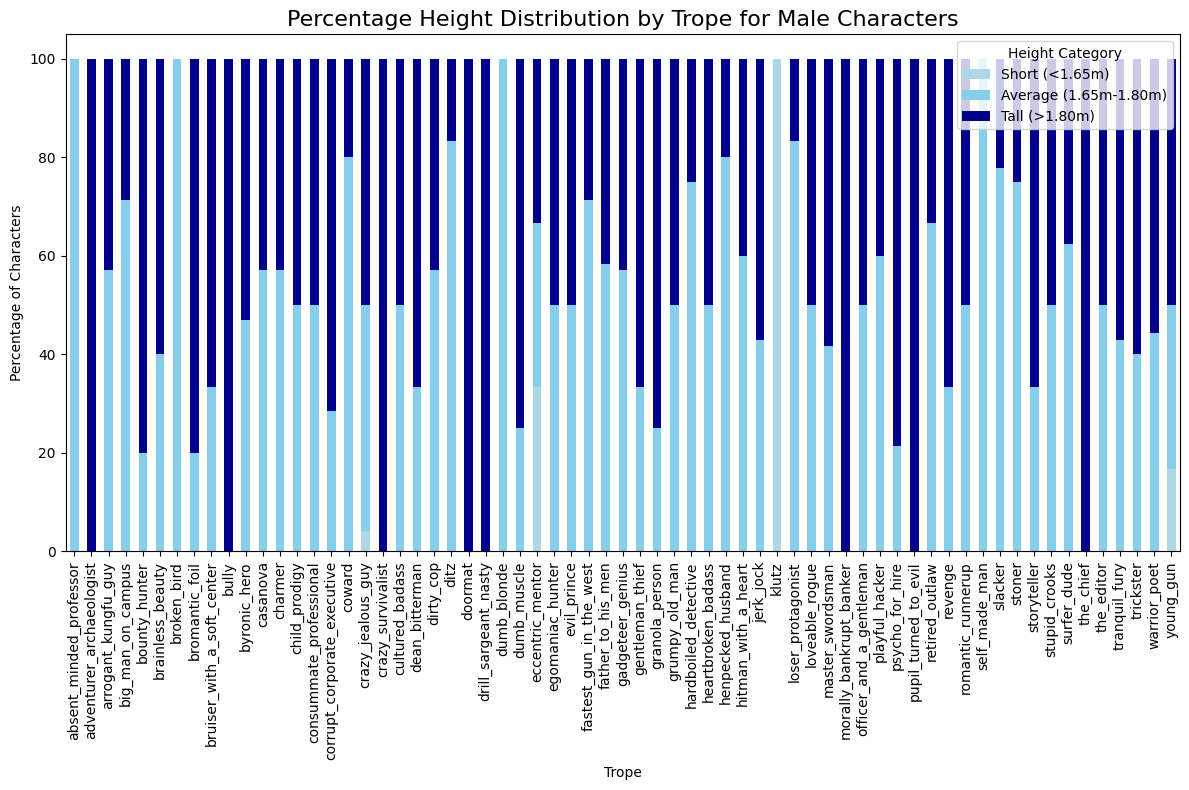

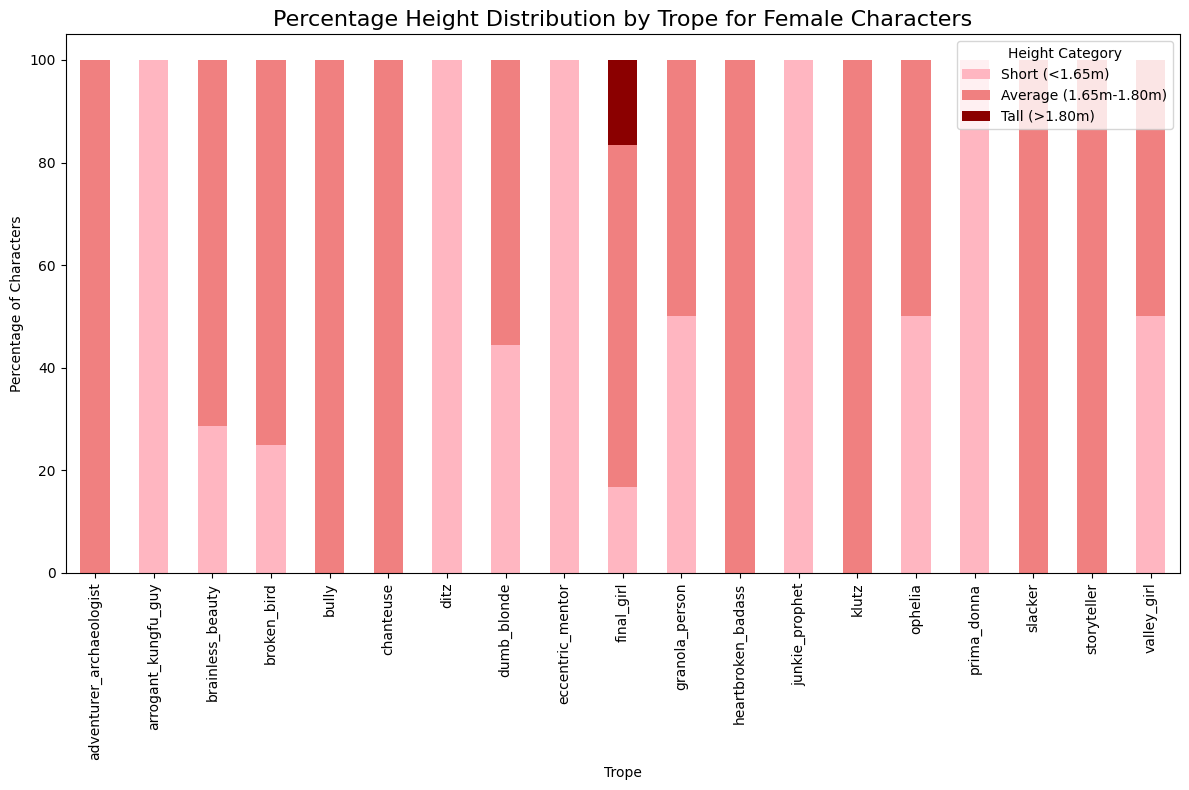

In [32]:
# Calculate the percentage distribution of each height category within each trope for men and women
height_distribution_m = tropes_m.groupby(['trope', 'height_category']).size().unstack().fillna(0)
height_distribution_m = height_distribution_m.div(height_distribution_m.sum(axis=1), axis=0) * 100
height_distribution_w = tropes_w.groupby(['trope', 'height_category']).size().unstack().fillna(0)
height_distribution_w = height_distribution_w.div(height_distribution_w.sum(axis=1), axis=0) * 100

# Plot for men with percentage values
fig, ax = plt.subplots(figsize=(12, 8))
height_distribution_m.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'skyblue', 'darkblue'])
ax.set_title("Percentage Height Distribution by Trope for Male Characters", fontsize=16)
ax.set_xlabel("Trope")
ax.set_ylabel("Percentage of Characters")
ax.legend(title="Height Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plot for women with percentage values
fig, ax = plt.subplots(figsize=(12, 8))
height_distribution_w.plot(kind='bar', stacked=True, ax=ax, color=['lightpink', 'lightcoral', 'darkred'])
ax.set_title("Percentage Height Distribution by Trope for Female Characters", fontsize=16)
ax.set_xlabel("Trope")
ax.set_ylabel("Percentage of Characters")
ax.legend(title="Height Category")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


* Ethnicity Distribution by Trope (we need to enrich our dataframe as the actor ethnicity need to be defined


In [24]:
ethnicity_distribution_w = tropes_w.groupby('trope')['actor_ethnicity'].value_counts(normalize=True)
ethnicity_distribution_m = tropes_m.groupby('trope')['actor_ethnicity'].value_counts(normalize=True)

print("Ethnicity distribution by trope for women:")
print(ethnicity_distribution_w)
print("\nEthnicity distribution by trope for men:")
print(ethnicity_distribution_m)

Ethnicity distribution by trope for women:
trope                     actor_ethnicity
adventurer_archaeologist  /m/013b6_          1.000000
brainless_beauty          /m/07bch9          0.200000
                          /m/042gtr          0.200000
                          /m/065b6q          0.200000
                          /m/02w7gg          0.200000
                          /m/0xnvg           0.200000
broken_bird               /m/01qhm_          0.500000
                          /m/04ydrsn         0.500000
chanteuse                 /m/065b6q          0.400000
                          /m/042gtr          0.200000
                          /m/04f581          0.200000
                          /m/07hwkr          0.200000
ditz                      /m/041rx           1.000000
dumb_blonde               /m/07bch9          0.428571
                          /m/0xnvg           0.142857
                          /m/03bkbh          0.142857
                          /m/041rx           0.1428